# Homework 1: Computing and Data Analysis Review



*Your Name:* Caleb Vaughan

Collaborated with Joey McClelland
ChatGPT used to help set y0 and use the solve_ivp function.

## Learning Objectives

In this homework assignment, you will review and practice the following skills from CBE 20258:
* [Plotting in Python](https://ndcbe.github.io/data-and-computing/notebooks/01/Matplotlib.html) including [best practices](https://ndcbe.github.io/data-and-computing/notebooks/01/Publication-Quality-Figures.html)
* [Solving initial value problems in Python](https://ndcbe.github.io/data-and-computing/notebooks/07/Systems-of-Differential-Equations-and-Scipy.html)
* [Nonlinear regression](https://ndcbe.github.io/data-and-computing/notebooks/15/Nonlinear-Regression.html) with [weights based on measurement uncertainty](https://ndcbe.github.io/data-and-computing/notebooks/15/Weighted-Regression.html)
* [Error propagation](https://ndcbe.github.io/data-and-computing/notebooks/12/Error-Propagation.html) coupled with [nonlinear regression](https://ndcbe.github.io/data-and-computing/notebooks/15/Nonlinear-Case-Study-Adsorptive-Membranes.html)
* Solving a boundary value problem by calculating the [root of a nonlinear function](https://ndcbe.github.io/data-and-computing/notebooks/06/Newton-Methods-in-Scipy.html)

Each topic links to pages on a website with the CBE 20258 content. The search feature on the CBE 20258 is a great way to find more related examples.

## Deadlines

Because this is a long assignment and each exercise builds on the previous one, we are having two deadlines:
1. Homework 1A: Exercises 1, 2, and 3 are due (in their entirety) on **Tuesday, January 20 (10 PM)**.
2. Homework 1B: Exercises 4, 5, 6, and 7 are due (in their entirety) on **Tuesday, January 27 (10 PM)**. You will also submit Excercises 2 and 3 again. (In other words, do not delete these Exercises from your notebook.)

Shortly after the first deadline, we will post the solutions for Exercises 1, 2, and 3. You are expected to check these solutions and fix any mistakes. We are doing this because Exercises 4 and beyond require correct solutions for the earlier exercises.

## Introduction

This homework problem is inspired, in part, by a [Wired blog post](https://www.wired.com/2011/12/cannon-balls-size-matters/) analyzing an incident with a cannonball on the popular show Myth Busters.

Consider $n$ iron cannonballs of mass 12 lb (5.44 kg) fired at unknown angles $\theta_i$ (where $i \in \{1,...,n\}$) with unknown initial velocities $v_{0,i}$. The drag on the cannonball is $F_D = \frac{1}{2} \rho C_D A v |v|$ where $\rho$ is the density of air, $C_D$ is the coefficient of drag, and $A$ is the cross sectional area of the cannonball. We can lump these parameters together into a single unknown coefficient $\bar{C}_D$:

\begin{equation}
F_D = \bar{C}_D v |v|
\end{equation}

It is important to use $v |v|$ to account for the change in sign when the cannonball transitions from moving upward to moving downward.

Applying Newton's laws of motion gives the following coupled differential equations:

\begin{equation}
m \frac{dv_x}{dt}=-\bar{C}_D v_x |v |, \quad m \frac{dv_z}{dt} = -mg - \bar{C}_D v_z | v |,   \quad \frac{dx}{dt} = v_x, \quad \frac{dz}{dt} = v_z, \quad |v| = \sqrt{v_x^2 + v_z^2}
\end{equation}

We assume the cannonball is fired from the origin at time $t=0$ where $x$ and $z$ represent horiztonal and vertical displacement, respectively. This gives the follow initial values:

\begin{equation}
x(0) = 0, \quad z(0) = 0, \quad v_x(0) = v_0 \cos(\theta), \quad v_z(0) = v_0 \sin(\theta)
\end{equation}

The $n$ cannonballs are fired on completely flat terrian. We observe the impact location (horizonal distance traveled), impact time, and crater size. The latter can be correlated with impact velocity:

| Time (s) | Horizontal Displacement (m) | Impact Velocity (m/s) |
| -------- | --------------------------- | --------------------- |
| 12.0     | 726                         | 73                    |
| 6.8      | 529                         | 77                    |
| 15.3     | 616                         | 76                    |

Given these data, our ultimate goals are:
* Build a mathematical model
* Estimate $\theta_i$, $v_{0,i}$ and $\bar{C}_D$
* Predict the distance traveled and impact velocity of a cannonball shot at a new angle and initial velocity with uncertainty


We will assume the time, location, and velocity measurements are corrupted with normally distributed noise with a standard deviations of 0.2 s, 5 m, and 2 m/s, respectively. When we do regression, we need to account for the fact that the velocity estimates (based on crater size) have greater uncertainty.

## Exercise 1

On paper, derive the above ordinary differential equation model from first principles, similar to Physics I. Start with a free body diagram. Use trigonomety to justify the initial conditions.

## Exercise 2

Write a Python function to numerical simulate a cannon ball experiment. The inputs to your function should be the unknown parameters $\theta_i$, $v_{0,i}$, and $\bar{C}_D$. Your function should return:
1. Final time $t_f > 0$ when the cannonball returns to zero elevation, i.e., $z(t_f) = 0$
1. Horizontal distance traveled, $x(t_f)$
2. Impact velocity, $v(t_f) = \sqrt{v_x(t_f)^2 + v_z(t_f)^2}$

Hints:
* Use `solve_ivp` in `SciPy` instead of implementing your our numeric integration scheme. This will be more accurate. In the past, students who implemented their our numeric integration routine here had trouble with later exercises due to accuracy issues.
* The [SciPy docmentation](https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.integrate.solve_ivp.html) and [Num Stats examples](https://ndcbe.github.io/data-and-computing/notebooks/07/Systems-of-Differential-Equations-and-Scipy.html#scipy) are helpful.
* You can use the `events` optional argument in `solve_ivp` to find the time the cannonball returns to elevation 0. This [example shows how to use the `events` feature](https://ndcbe.github.io/controls/notebooks/2/One-Compartment-Pharmacokinetics.html).
* In the `SciPy` documentation for the `events` feature, look at the attributes `.terminal` and `.direction`. These are helpful.
* For a majority of students, spending 15 minutes to learn how to use the `events` feature is a lot less time then writing and debugging their own code to find the impact time, velocity, and distance.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
%matplotlib inline

def ode_rhs(t, y, Cd):
    """ODE system for a cannonball with drag
    Arguments:
        t: time (s)
        y: state vector [x, z, vx, vz] (m, m, m/s, m/s)
        Cd: drag coefficient (kg/m)

    Returns:
        dy: time derivative of the state vector [vx, vz, ax, az] (m/s, m/s, m/s^2, m/s^2)

    """

    x, z, vx, vz = y
    vabs = np.sqrt(vx**2 + vz**2)

    g = 9.81 # m/s^2
    m = 5.44 # kg

    ax = -Cd*vabs*vx/m
    az = -Cd*vabs*vz/m - g

    dy = [vx, vz, ax, az]
    return dy

# This function provides an event for the solve_ivp to recognize that the cannon ball has hit the ground
def hits_ground(t, y, Cd):
  return y[1]
hits_ground.terminal = True
hits_ground.direction = -1

def simulate_experiment(Cd, angle, v0=100, tmax=200, plot=True, tdata=None, xdata=None, vdata=None):
    """Simulate an experiment.

    Arguments:
        Cd: drag coefficient (kg/m)
        angle: launch angle (degrees)
        v0: initial speed (m/s)
        tmax: maximum time (s)
        plot: bool, if true, plot simulation results and data
        tdata: measured impact time (s) [only used for plotting]
        xdata: measured impact location (m) [only used for plotting]
        vdata: inferred impect velocity (m/s) [only used for plotting]

    Returns:
        tfinal: final time (s)
        xfinal: final x position (m)
        vfinal: final speed (m/s)

    """
    y = [0, 0, v0*np.cos(np.deg2rad(angle)), v0*np.sin(np.deg2rad(angle))]
    y0 = y
    soln = integrate.solve_ivp(ode_rhs, (0, tmax), y0, events=hits_ground, args=(Cd,), max_step=0.1)
    tfinal = soln.t[-1]
    xfinal = soln.y[0][-1]
    vfinal = np.sqrt(soln.y[2][-1]**2 + soln.y[3][-1]**2)

    if plot:
        t = soln.t
        x = soln.y[0]
        z = soln.y[1]
        vx = soln.y[2]
        vz = soln.y[3]
        v = np.sqrt(vx**2 + vz**2)

        plt.figure(figsize=(8,8))

        fig, axs = plt.subplots(2, 1, figsize=(8,8))

        ax1 = axs[0]
        ax1_right = ax1.twinx()
        ax2 = axs[1]
        ax1.plot(t, x, label='x(t) - Horizontal Displacement')
        ax1_right.plot(t, z, color = 'red', label='z(t) - Vertical Displacement')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Horizontal Displacement (m)')
        ax1_right.set_ylabel('Vertical Displacement (m)')
        ax1.legend()
        ax1_right.legend(loc='right')
        ax1.scatter(tdata, xdata, label='Data') # Plot data point
        ax1.set_title('Horizontal and Vertical Displacement vs. Time')


        ax2.plot(t, v, label='v(t) - Total Velocity')
        ax2.plot(t, vx, label='vx(t) - Horizontal Velocity')
        ax2.plot(t, vz, label='vz(t) - Vertical Velocity')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Velocity (m/s)')
        ax2.scatter(tdata, vdata, label='Data') # Plot data point
        ax2.set_title('Velocity vs. Time')
        ax2.legend()

        plt.tight_layout()

    return tfinal, xfinal, vfinal

## Exercise 3

Test your function by simulating the provided data for the cannonball experiments. For each experiment, make a plot showing the model predictions (lines) and observed data (symbols). You can use the data given below as intial guesses for $\theta_{i}$ and $v_{0,i}$. You can use $\bar{C_D} = 0.003$ as an intial guess for the coefficient of drag.

In [2]:
import pandas as pd

data = {}
data['time'] = [12.0, 6.9, 15.3]
data['distance'] = [726., 529., 616.]
data['velocity'] = [73., 77., 76.]
data['theta_guess'] = [40., 20., 60.]
data['v0_guess'] = [110., 100., 90.]
df = pd.DataFrame(data)
df.head()

,time,distance,velocity,theta_guess,v0_guess
0,12.0,726.0,73.0,40.0,110.0
1,6.9,529.0,77.0,20.0,100.0
2,15.3,616.0,76.0,60.0,90.0


<Figure size 800x800 with 0 Axes>

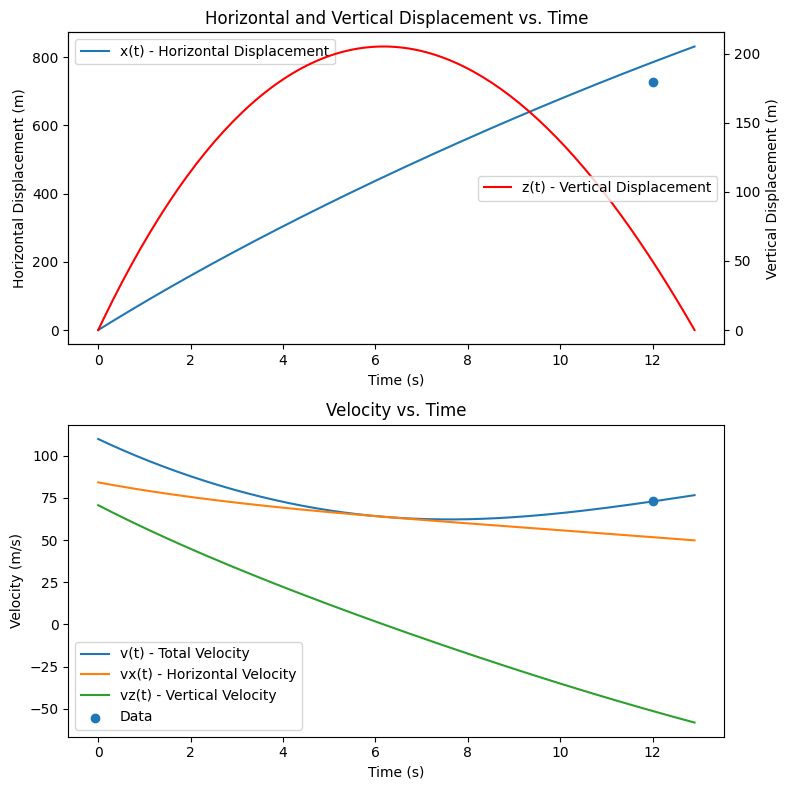

<Figure size 800x800 with 0 Axes>

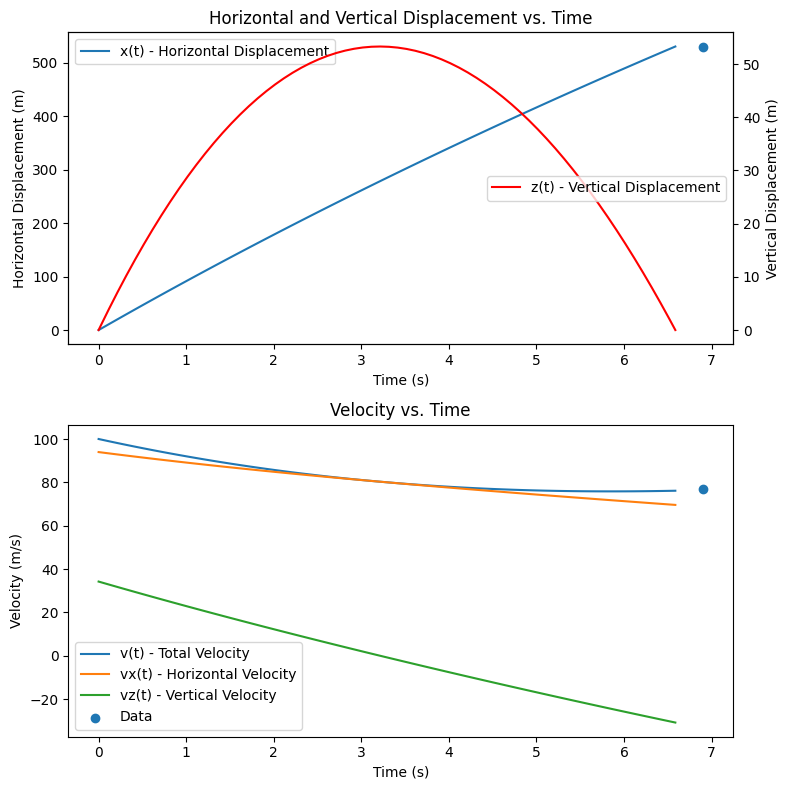

<Figure size 800x800 with 0 Axes>

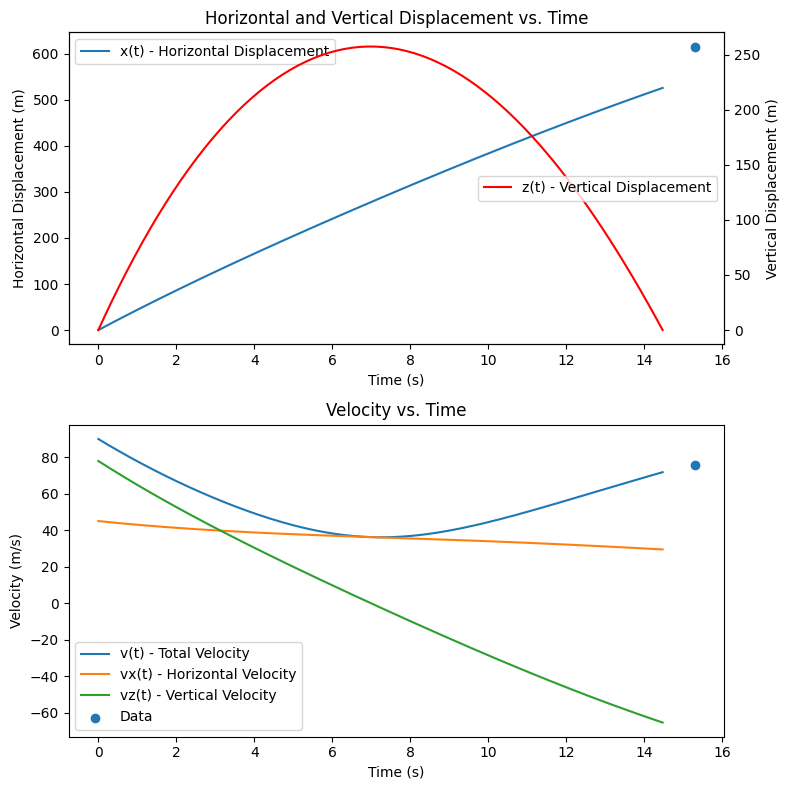

In [3]:
# Confirm your plots show both the simulation results (lines)
# and experimental data (symbols)
for i, row in df.iterrows():
    simulate_experiment(0.003,
                        row.theta_guess,
                        xdata=row.distance,
                        vdata=row.velocity,
                        tdata=row.time,
                        v0=row.v0_guess,
                        plot=True)



## Exercise 4

Perform nonlinear regression to estimate $\bar{C}_D$, $\theta_1$, ..., $\theta_n$, $v_{0,1}$, ..., $v_{0,n}$. Report the estimate parameters with a reasonable number of significant digits. Include plots to compare the model predictions and experiment data.

In [4]:
from scipy.optimize import least_squares

def unpack(param):
    """ Unpacks the vector "param"

    Arguments:
        param: vector [Cd, theta1, theta2, ..., thetaN, v01, v02, ..., v0N]

    Returns,
        Cd: lumped drag coefficient (kg/m)
        theta: launch angles (degrees)
        v0: initial speeds (m/s)

    """
    n = (len(param) - 1 )//2
    Cd = param[0]
    theta = param[1:(n+1)]
    v0 = param[(n+1):(2*n+1)]
    return Cd, theta, v0

def pack(Cd, theta, v0):
    """ Packs the parameters into a vector

    Arguments:
        Cd: lumped drag coefficient (kg/m)
        theta: launch angles (degrees)
        v0: initial speeds (m/s)

    Returns:
        param: vector [Cd, theta1, theta2, ..., thetaN, v01, v02, ..., v0N]
    """
    return np.hstack([Cd, theta, v0])

# Assumed standard deviation of measurement error
sigma_t = 0.2 # s
sigma_x = 5 # m
sigma_v = 2 # m/s

def residuals_all(parameter_vec, data, plot=False):
    """
    Computes the residuals for all experiments

    Arguments:
        parameter_vec: vector [Cd, theta1, theta2, ..., thetaN, v01, v02, ..., v0N]
        data: dataframe with experimental data
        plot: bool, if true, plot simulation results and data

    Returns:
        residuals: vector of residuals scaled by the measurement uncertainty
    """

    n = len(data)

    Cd, theta, v0 = unpack(parameter_vec)

    # Allocate matrix for residuals, n experiments (rows) with 3 measurements per experiment (columns)
    residuals = np.zeros((n,3))

    # Loop over experiments
    for i, row in data.iterrows():
        # Simulate experiment
        tsim, xsim, vsim = simulate_experiment(Cd,
                        theta[i],
                        v0 = v0[i],
                        xdata=row.distance,
                        vdata=row.velocity,
                        tdata=row.time,
                        plot=plot)

        # Compute and record scaled residuals
        residuals[i,0] = (tsim - row.time)/sigma_t
        residuals[i,1] = (xsim - row.distance)/sigma_x
        residuals[i,2] = (vsim - row.velocity)/sigma_v

    # Flatten the residual matrix into a vector
    return residuals.reshape(3*n)


# Define initial guess
initial_vector = pack([0.003], df.theta_guess.to_numpy(), df.v0_guess.to_numpy())

# Evaluate residuals at initial guess
print(residuals_all(initial_vector,df,plot=False))


[  4.52682473  20.96061968   1.83763028  -1.57300631   0.34408466
  -0.43771039  -4.09438986 -17.99363626  -2.09672272]


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.0547e+02                                    1.86e+05    
       1              2         1.8105e+00      4.04e+02       1.44e+01       6.26e+03    
       2              3         6.0661e-01      1.20e+00       7.41e-01       4.24e+01    
       3              4         6.0650e-01      1.13e-04       1.18e-02       4.92e-03    
       4              5         6.0650e-01      1.17e-08       4.83e-04       8.80e-03    
       5              6         6.0650e-01      1.26e-11       7.67e-06       1.74e-04    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 4.0547e+02, final cost 6.0650e-01, first-order optimality 1.74e-04.
Cd = 0.0027  kg/m

Experiment 1
theta = 40.7 degrees
v0 = 98.2 m/s

Experiment 2
theta = 21.4 degrees
v0 = 96.1 m/s

Experiment 3
theta = 58.7 degrees
v0 = 96.5 m/s


array([-0.01111086, -0.04987509,  0.53852914, -0.54153115,  0.18923986,
       -0.74223711, -0.04937722, -0.00876448,  0.19461621])

<Figure size 800x800 with 0 Axes>

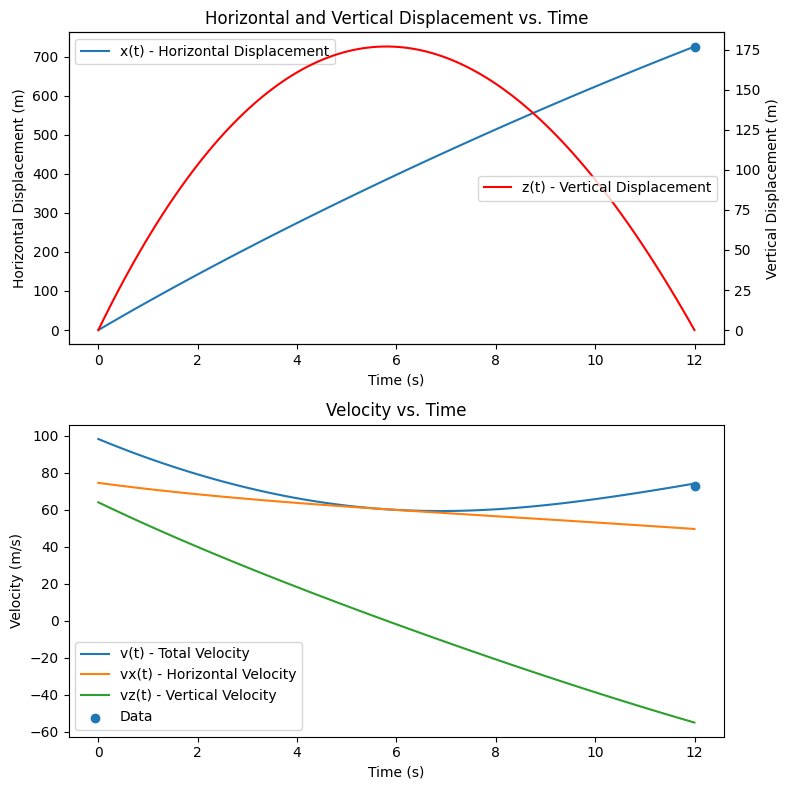

<Figure size 800x800 with 0 Axes>

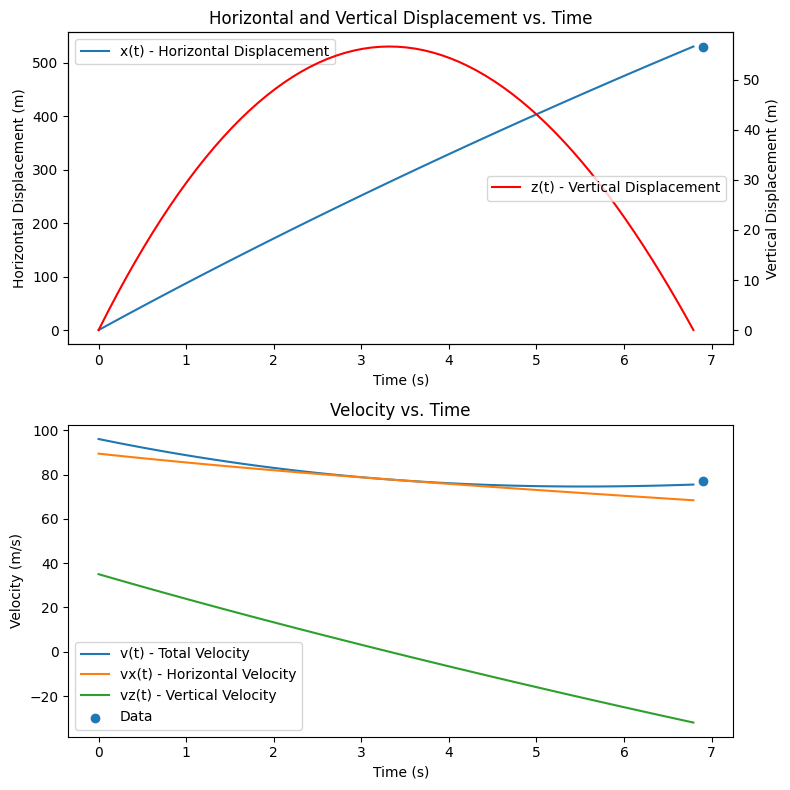

<Figure size 800x800 with 0 Axes>

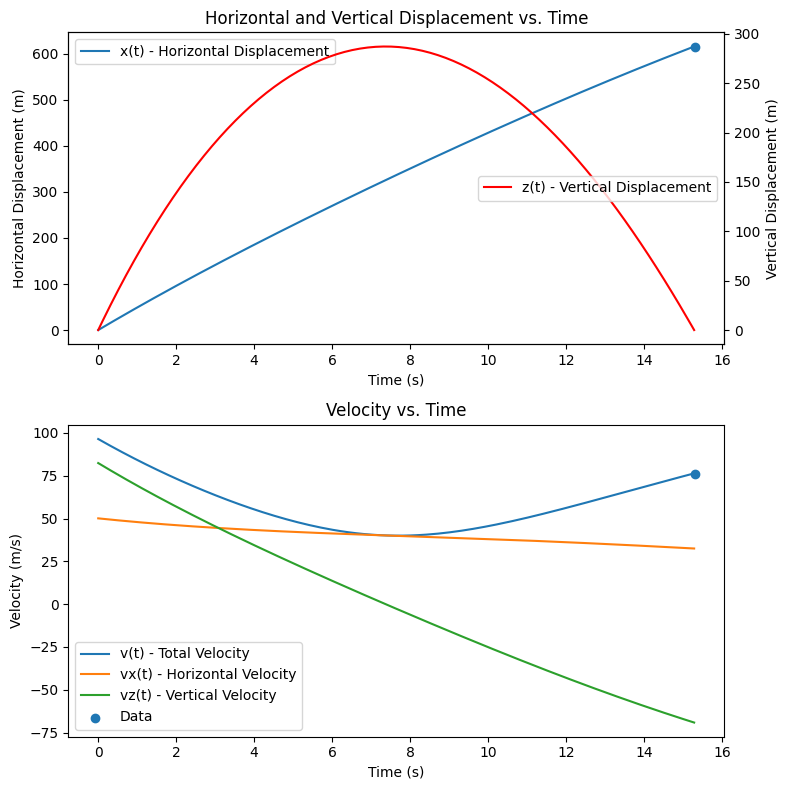

In [5]:
# Perform nonlinear regression

sln = least_squares(residuals_all, initial_vector, args=(df,), verbose=2)

# Determine the number of experiments
n = len(df)

# Extract the estimated parameters
Cd_est = sln.x[0]
theta_est = sln.x[1:(n+1)]
v0_est = sln.x[(n+1):(2*n+1)]

# Print the results (with rounding and units)
print("Cd =",round(Cd_est,4)," kg/m")
for i in range(0,n):
    print("\nExperiment",i+1)
    print("theta =",round(theta_est[i],1),"degrees")
    print("v0 =",round(v0_est[i],1),"m/s")


# Plot the experimental data and the simulation results
residuals_all(sln.x, df, True)

## Exercise 5

Quantify the uncertainty in your parameter estimates. *Hint:* Calculate the covariance matrix and correlation matrix of the estimated parameters.

In [18]:
print(sln.x)

[2.67418787e-03 4.06560967e+01 2.13876716e+01 5.86931981e+01
 9.81567929e+01 9.60847125e+01 9.64520280e+01]


In [7]:
# Add your solution here

In [11]:
n_params = len(sln.x)
n_measurements = len(df) * 3 # 3 measurements per experiment (time, distance, velocity)
degrees_of_freedom = n_measurements - n_params

# sln.cost is the sum of squares of the scaled residuals'
J = sln.jac
cov = np.linalg.inv(J.T @ J)

# print(cov)
unc = np.sqrt(np.diag(cov))

# print uncertainties
for i in range(0,n):.3
    print("\nExperiment",i+1)
    print("theta uncertainty =",round(unc[i+1],1),"degrees")
    print("v0 uncertainty =",round(unc[i+n+1],1),"m/s")


Experiment 1
theta uncertainty = 1.1 degrees
v0 uncertainty = 2.4 m/s

Experiment 2
theta uncertainty = 1.1 degrees
v0 uncertainty = 3.1 m/s

Experiment 3
theta uncertainty = 0.8 degrees
v0 uncertainty = 2.2 m/s


In [ ]:
# Add your solution here

In [ ]:
# Add your solution here

In [ ]:
# Add your solution here

Interpret your uncertianty estimate in a few sentences.

*Answer*: Uncertainity was relatively similar between the three experiments for both variables. These values are not negligible, but have magnitudes at least one order of magnitude smaller than the actual values, so we can have decent confidence in our results.

In a few sentences, describe and justify your choice of uncertainty quantification method. In other words, what are the pros and cons of the selected method and why it is a reasonable choice for this problem.

*Answer*: I chose to use a first-order linear model for uncertainty because
it is a simpler model with less computational cost. It works well for systems with smooth curves and small relative uncertainty - I feel that description fits our system well.

## Exercise 6

Determine the firing angle $\theta_j$ and intial velocity $v_{0,j}$ to hit a target at 300 m with an impact velocity of 80 m/s.

In [14]:


from scipy.optimize import fsolve

def firing_residuals(guess):
    """ Residuals for the firing experiment

    Arguments:
        guess: vector [angle in deg, v0 in m/s]

    Returns:
        residuals: vector [position, impact speed]


    """
    # Pull initial guess values from function input
    angle = guess[0]
    v0 = guess[1]

    # Determine simulated variables based on function we defined earlier
    results = simulate_experiment(Cd_est, angle, v0=v0, plot=False)
    vsim = results[2]
    xsim = results[1]
    tsim = results[0]

    # Define residuals which will be minimized later
    r_x = xsim - 300
    r_v = vsim - 80

    return [r_x, r_v]

# Now we make a random guess and use the function
initial_guess = [50, 100]
solve = fsolve(firing_residuals, initial_guess)
theta_j = solve[0]
v0_j = solve[1]

print("Firing angle =",round(theta_j,1),"degrees")
print("Initial velocity =",round(v0_j,1),"m/s")
#

Firing angle = 77.7 degrees
Initial velocity = 98.0 m/s


## Exercise 7

Quantify and interpret the uncertainty in your prediction (distance, time, velocity) from the previous exercise. Assume you can specify the firing angle and initial velocity with uncertainties of 1 degree and 2 m/s, respectively. You also have some uncertainty in your estimate of $C_D$ (quantified above).

Hints:
* Calculate the covariance matrix and correlation matrix for the predicted displacement and impact velocity.
* You learned two ways to perform uncertainty propagation in Num Stats: first-order error propagation and Monte Carlo. Both approaches, when properly implemented, are suitable for this task.
* Start by writing some pseudocode. If you are performing first-order error propagation, write on paper the governing equation. Then work out the dimensions of all of the matrices. Likewise, for Monte Carlo error propagation, write pseudocode with all of the logical steps. If you need help with this Exercise, expect the TAs and Instructor(s) to ask to see you pseudocode.
* Be sure you are considering uncertainty in all three inputs: $C_D$ (Exercise 6), $v_{0}$ (problem statement), and $\theta$ (problem statement).

In [17]:
# Add your solution here

# Here is code copied from CBE 20258 notebooks that you may find helpful
# You can also answer this question without calculating a Jacobian
def Jacobian(f,x,delta = 1.0e-7):
    '''Approximate Jacobian using forward finite difference

    Args:
        f: vector-valued function
        x: point to build approximation J(x) around
        delta: finite difference step size

    Returns:
        J: m x n Jacobian matrix (approximation), where
            n = length of x
            m = length of f(x)

    Reference:
        https://ndcbe.github.io/data-and-computing/notebooks/06/Newton-Raphson-Methods-for-Systems-of-Equations.html

    '''


    #Evaluate function f at x
    fx = f(x) #only need to evaluate this once

    # Determine size
    N = x.size
    M = fx.size

    # Allocate empty matrix
    J = np.zeros((M,N))

    idelta = 1.0/delta #division is slower than multiplication
    x_perturbed = x.copy() #copy x to add delta

    # Loop over elements of x and columns of J
    for i in range(N):
        # Perturb (apply step) to element i of x
        x_perturbed[i] += delta

        # Approximate column in Jacobian
        col = (f(x_perturbed) - fx) * idelta

        # Reset element of x
        x_perturbed[i] = x[i]

        # Save results
        J[:,i] = col
    # end for loop
    return J


# Known uncertainties
sigma_theta_j = 1.0 # degrees (given in problem statement)
sigma_v0_j = 2.0 # m/s (given in problem statement)
Cd_est = Cd_est # this was calculated earlier, I'm just displaying again for ease of conscience


# The purpose of this function is to take our inputs, run the simulate experiment function, and return outputs in a way the jacobian function can understand.
def predict_impact(parameters):
    Cd, theta, v0 = parameters
    tfinal, xfinal, vfinal = simulate_experiment(Cd, theta, v0=v0, plot=False)
    return np.array([tfinal, xfinal, vfinal]) # This array format is necessary for the jacobian

# now we define the x that is needed for the jacobian function (it's just a vector of our parameters)
x = np.array([Cd_est, theta_j, v0_j]) # These values come from previous exercises

# Finally, we can use the jacobian function to find J
J = Jacobian(predict_impact, x)

# Since we assume input are independent, covariance matrix is just the diagonals - which is comprised of uncertainties squares
cov_inputs = np.diag([Cd_est**2, sigma_theta_j**2, sigma_v0_j**2]) # Must square uncertainties to get variance

# 6. Propagate the uncertainty using the formula Sigma_out = J_prop @ Sigma_in @ J_prop.T
Sigma_out = J_prop @ Sigma_in @ J_prop.T

# 7. Extract the standard deviations of the predicted outputs
std_tfinal = np.sqrt(Sigma_out[0,0])
std_xfinal = np.sqrt(Sigma_out[1,1])
std_vfinal = np.sqrt(Sigma_out[2,2])

print(f"\nUncertainty in predicted impact time: {std_tfinal:.2f} s")
print(f"Uncertainty in predicted horizontal distance: {std_xfinal:.2f} m")
print(f"Uncertainty in predicted impact velocity: {std_vfinal:.2f} m/s")

# The previous lines calculating cov and unc directly from J and x are removed as they are not correct for this purpose.


Uncertainty in predicted impact time: 0.38 s
Uncertainty in predicted horizontal distance: 26.78 m
Uncertainty in predicted impact velocity: 2.26 m/s


Please interpret the uncertainty in your predictions. How do these results compare to the measurement uncertainty?

*Answer*: Time uncertainty is .38s which seems small, but we have frame of reference, so it is hard to say whehter is is relatively small. Displacement uncertainty is nearly 10% of final displacement (26.78m vs 300m). This is not ideal and is likely because it is highly sensitive to changes in the input parameters (v0 and theta). Although not specified in the problem statement, the measurement uncertainty of travel distance is probably comparably quite small (I would guess within about .5 meters). Impact velocity uncertainty is relatively low (2.26 m/s compared to a total velocity of 80 m/s) and also very similar to the measurement uncertainties 2 m/s.

## Submission Instructions

Please submit your answer to Exercise 1, neatly written on paper, to Gradescope as a PDF. Please submit your answers to the remaining exercises in this notebook (.ipynb file) to Gradescope. There are two separate assignments on Gradescope.

## Declarations

**Collaboration**: I worked closely with Joey McClelland on this assignment. We collaborated throughout and explained reasoning to each other when we got stuck.

**Generative AI**: For 1B, in exercise 7, Colab's built-in chatbot helped me solve the uncertainties by helping me with a hurdle: I had previously called the incorrect functions into the Jacobian function. It also helped me understand why the distance uncertainty was so great.